# ***Kaggle:*** Chess Evaluations

| Author's Name         | NIU     |
| --------------------- | ------- |
| Albert Capdevila      | 1587933 |

<small>*This Jupyter Notebook is submitted as an assignment for the Machine Learning subject in the Computer Engineering degree at the Universitat Autònoma de Barcelona (UAB).*<small>

## 1. Problem definition

In computer chess, an evaluation function estimates the strength of a position by assigning a numerical score that indicates which side (White or Black) has the advantage and by how much.

This score is based on the values of chess pieces, which are traditionally:
| Piece  | Pawn | Knight | Bishop | Rook | Queen |
|--------|------|--------|--------|------|-------|
| Symbol | ![Pawn](https://upload.wikimedia.org/wikipedia/commons/thumb/4/45/Chess_plt45.svg/45px-Chess_plt45.svg.png) | ![Knight](https://upload.wikimedia.org/wikipedia/commons/thumb/7/70/Chess_nlt45.svg/45px-Chess_nlt45.svg.png) | ![Bishop](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b1/Chess_blt45.svg/45px-Chess_blt45.svg.png) | ![Rook](https://upload.wikimedia.org/wikipedia/commons/thumb/7/72/Chess_rlt45.svg/45px-Chess_rlt45.svg.png) | ![Queen](https://upload.wikimedia.org/wikipedia/commons/thumb/1/15/Chess_qlt45.svg/45px-Chess_qlt45.svg.png) |
| Value  | 1    | 3      | 3      | 5    | 9     |

<small>*The value of the king is undefined as it cannot be captured, let alone traded, during the course of the game. Chess engines usually assign the king an arbitrary large value such as 200 points [[1]](#references).*</small>

These values show that, for example, capturing a bishop is equivalent to capturing three pawns. Therefore, all of them can be expressed in *'pawn units'*.

It’s also important to note that evaluations are opposite, with positive values indicating an advantage for White and negative values for Black. For example, a negative evaluation of $-3$ pawns may indicate that Black has an advantage equivalent to three pawns, a bishop, or a knight.

Usually, these evaluations are calculated by complex algorithms, such as *Stockfish*, which are based on **minimax** principles, calculating, pruning, and predicting the best moves across multiple levels of depth. These algorithms can be slow and computationally intensive, as they analyze many possible future moves in a position. This notebook will explore the use of regression models to achieve similar results more quickly.

***In this notebook, we aim to estimate the evaluation score of a chess position through feature extraction and simple regression techniques.***



## 2. Data collection

For this machine learning problem, we will use the **Chess Evaluations** dataset, available [here](https://www.kaggle.com/datasets/ronakbadhe/chess-evaluations/data) on Kaggle. The dataset contains two columns: 

| Feature             | Description                                                                 |
|---------------------|-----------------------------------------------------------------------------|
| **Position (FEN)**  | This is a string representing the chess position in Forsyth-Edwards Notation (FEN). |
| **Evaluation**      | This is the evaluation of the position in ***centipawns***. `#` means that there is forced checkmate. |

Let’s download and import the dataset:

In [21]:

from kaggle.api.kaggle_api_extended import KaggleApi
from zipfile import ZipFile
from tqdm import tqdm
import pandas as pd
import numpy as np
import re
import os 

api = KaggleApi()
api.authenticate()

dataser_owner = 'ronakbadhe'
dataset_name= 'chess-evaluations'
dataset = f'{dataser_owner}/{dataset_name}'
target = 'Evaluation'

if not os.path.isdir('data'):
  print("The 'data' directory was not found")
  print("Downloading the dataset from Kaggle...")
  os.mkdir('data')
  api.dataset_download_files(dataset = dataset,path = 'data')
  zf = ZipFile(f'data/{dataset_name}.zip')
  zf.extractall(f'data')
  zf.close()
  os.remove(f'data/{dataset_name}.zip')
  print("Dataset downloaded successfully ✓")
else:
  print("The 'data' directory was found successfully ✓")

The 'data' directory was found successfully ✓


In [22]:
csvFile = "chessData.csv"
print(f"Reading the file '{csvFile}'...")

df = pd.read_csv(f'data/{csvFile}')

print(f"File '{csvFile}' read successfully ✓")

Reading the file 'chessData.csv'...
File 'chessData.csv' read successfully ✓


In [23]:
# Reducing the dataset size to make it faster to work with
from sklearn.model_selection import train_test_split

_, df = train_test_split(df, test_size=0.001, random_state=42)

In [24]:
df.head()

,FEN,Evaluation
11784899,r3k2r/1b2bppp/p1n1pn2/1p2N1B1/8/2NB1P2/PPP3PP/...,-35
8860705,r3k2r/1pp2p2/1bnp1q2/p2Bp1p1/PP2P1bP/1QPP1N2/3...,-201
7376649,6k1/2p3pp/8/8/P3R3/3r1PP1/5K1P/8 b - - 0 30,+121
2224083,1r6/2rnppkp/1q1p2n1/2pP2p1/2b5/1P4PP/P1QNPPB1/...,+280
4108821,5k2/3R4/1p1p4/3n2pp/8/8/PP6/6K1 b - - 1 35,+328


## 3. Data preprocessing

### 3.1 Missing Data

In [25]:
df.isna().sum()

FEN           0
Evaluation    0
dtype: int64

Since there are no missing values, there is no need to handle NaN values.

### 3.2 Data Conversion

In [26]:
df.dtypes

FEN           object
Evaluation    object
dtype: object

The evaluation feature is a string that starts with either a "+" or "-" symbol. To use it in the model, it will need to be converted into a numeric value.

It may also include the character `#`, but since this is not relevant to the current problem, we will ignore it.

In [27]:
tqdm.pandas(desc="Converting 'Evaluation' to numeric values")
df['Evaluation'] = df['Evaluation'].progress_apply(lambda x: int(x) if '#' not in x else int(x.replace('#', '')))

Converting 'Evaluation' to numeric values: 100%|██████████| 12959/12959 [00:00<00:00, 588233.86it/s]


In [28]:
df.dtypes

FEN           object
Evaluation     int64
dtype: object

### 3.3 Data Normalization

Apart from the target feature (Evaluation), the dataset contains only one feature: FEN, which cannot be normalized. Therefore, normalization is not applicable in this case.

### 3.4 Feature extraction

In this section, we will focus on feature extraction, which is the most important step in building our model to predict the evaluation of a chess position. At the moment, we only have the FEN notation of the chess position, and our goal is to extract useful features from it.

#### 3.4.1 Information in the FEN Notation

Forsyth–Edwards Notation (FEN) is a standard notation for describing a particular board position of a chess game.

A typical FEN string looks like this: `rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq e3 0 1`

The FEN string above represents the following board position:

<img src="img/example_board.svg" alt="Example Board" width="300"/>

A FEN string has six fields, each separated by a space:

1. **Piece placement data:**

    It is the arrangement of pieces on the board, row by row, from top to bottom. Each piece is represented by a letter (uppercase for White and lowercase for Black). Empty squares are indicated by numbers.

2. **Active color:**

    Indicates which side is to move (`w` for White, `b` for Black).

3. **Castling availability:**

    If no castling is possible, this field is `-`. Otherwise, it shows `K`, `Q`, `k`, or `q` for available castling options.

4. **En passant target square:**

    Indicates the square where an en passant capture is possible, or `-` if not.

5. **Halfmove clock:**

    Counts the number of halfmoves since the last pawn advance or capture, used for the 50-move rule. 

6. **Fullmove number:**

    Tracks the total number of moves in the game, starting at 1 and incrementing after each Black move.

Only using this information, we can start extracting some simple new features:

In [29]:
def count_white_pieces(fen):
    return len(re.findall(r'[KQRBNP]', fen))

def count_black_pieces(fen):
    return len(re.findall(r'[kqrbnp]', fen))

tqdm.pandas(desc="Adding column 'White_pieces_count'")
df['White_pieces_count'] = df['FEN'].progress_apply(count_white_pieces)
tqdm.pandas(desc="Adding column 'Black_pieces_count'")
df['Black_pieces_count'] = df['FEN'].progress_apply(count_black_pieces)

Adding column 'Black_pieces_count': 100%|██████████| 12959/12959 [00:00<00:00, 157990.62it/s]


In [30]:
piece_values = {
    'P': 1, 'N': 3, 'B': 3, 'R': 5, 'Q': 9, 'K':200,
    'p': -1, 'n': -3, 'b': -3, 'r': -5, 'q': -9, 'k':-200
}

# The king's value is ignored for now.

def get_white_material(fen):
    return sum(piece_values[piece] for piece in re.findall(r'[QRBNP]', fen))

def get_black_material(fen):
    return -sum(piece_values[piece] for piece in re.findall(r'[qrbnp]', fen))

tqdm.pandas(desc="Adding column 'White_material'")
df['White_material'] = df['FEN'].progress_apply(get_white_material)

tqdm.pandas(desc="Adding column 'Black_material'")
df['Black_material'] = df['FEN'].progress_apply(get_black_material)

df["Material_difference"] = df['White_material'] - df['Black_material']
print("Added column 'Material_difference' ✓")

Adding column 'White_material':   0%|          | 0/12959 [00:00<?, ?it/s]

Adding column 'Black_material': 100%|██████████| 12959/12959 [00:00<00:00, 132194.43it/s]

Added column 'Material_difference' ✓


In [31]:
def get_turn(fen):
    return 1 if fen.split(' ')[1] == 'w' else -1

tqdm.pandas(desc="Adding column 'Turn'")
df['Turn'] = df['FEN'].progress_apply(get_turn)

Adding column 'Turn': 100%|██████████| 12959/12959 [00:00<00:00, 497997.94it/s]


In [32]:
def get_castling(fen, char):
    return int(char in fen.split(' ')[2])

tqdm.pandas(desc="Adding column 'White_king_castling'")
df['White_king_castling'] = df['FEN'].progress_apply(lambda fen: get_castling(fen, 'K'))

tqdm.pandas(desc="Adding column 'White_queen_castling'")
df['White_queen_castling'] = df['FEN'].progress_apply(lambda fen: get_castling(fen, 'Q'))

tqdm.pandas(desc="Adding column 'Black_king_castling'")
df['Black_king_castling'] = df['FEN'].progress_apply(lambda fen: get_castling(fen, 'k'))

tqdm.pandas(desc="Adding column 'Black_queen_castling'")
df['Black_queen_castling'] = df['FEN'].progress_apply(lambda fen: get_castling(fen, 'q'))

Adding column 'Black_queen_castling': 100%|██████████| 12959/12959 [00:00<00:00, 479502.32it/s]


In [33]:
def get_en_passant(fen):
    # This feature is 1 if en passant is available for White, -1 for Black, and 0 if none
    return int(fen.split(' ')[3] != '-') * 1 if fen.split(' ')[1] == 'w' else -1

tqdm.pandas(desc="Adding column 'En_passant'")
df['En_passant'] = df['FEN'].progress_apply(get_en_passant)

Adding column 'En_passant': 100%|██████████| 12959/12959 [00:00<00:00, 462370.68it/s]


In [34]:
def get_n_moves(fen):
    return int(fen.split(' ')[5]) + int(fen.split(' ')[1] == 'b')

tqdm.pandas(desc="Adding column 'N_moves'")
df['N_moves'] = df['FEN'].progress_apply(get_n_moves)

Adding column 'N_moves': 100%|██████████| 12959/12959 [00:00<00:00, 392532.57it/s]


Let's see the correlations between the new features and the target variable:

In [35]:
correlations = df.corr(numeric_only=True)['Evaluation']
sorted_correlations = correlations.reindex(correlations.abs().sort_values(ascending=False).index)
print("Correlations with 'Evaluation' (sorted by absolute value):")
print(sorted_correlations)

Correlations with 'Evaluation' (sorted by absolute value):
Evaluation              1.000000
Material_difference     0.195666
White_pieces_count      0.052898
White_material          0.036804
Black_pieces_count     -0.031224
En_passant              0.028921
Turn                    0.028843
Black_material         -0.017215
N_moves                -0.007546
Black_king_castling     0.001712
White_king_castling    -0.000689
White_queen_castling   -0.000240
Black_queen_castling   -0.000061
Name: Evaluation, dtype: float64


There are no significant correlations.

Currently, we only extract information from the FEN string, not from the position itself (for instance, two positions with the same pieces, turn, en passant, and number of moves would appear identical to the model).

We need to extract information directly from the game. To achieve this, we'll use the chess library to obtain a board representation and apply some of its functions to build new features.

In [ ]:
%pip install chess
import chess

Note: you may need to restart the kernel to use updated packages.


In [37]:
def get_board(fen):
    return chess.Board(fen)

tqdm.pandas(desc="Adding column 'Board'")
df['Board'] = df['FEN'].progress_apply(get_board)

Adding column 'Board': 100%|██████████| 12959/12959 [00:01<00:00, 9991.53it/s] 


Here are a few features I think could have a strong correlation with the evaluation:

* **Attack count:**
    It is the number of squares attacked by each individual piece of a player. If a square is attacked by more than one piece, it is counted multiple times.

In [38]:
def get_attacks_count(board, color):
    return sum(len(board.attackers(color, square)) for square in chess.SQUARES)

tqdm.pandas(desc="Adding column 'White_attacks'")
df['White_attacks'] = df['Board'].progress_apply(lambda board: get_attacks_count(board, chess.WHITE))

tqdm.pandas(desc="Adding column 'Black_attacks'")
df['Black_attacks'] = df['Board'].progress_apply(lambda board: get_attacks_count(board, chess.BLACK))

df["Attacks_difference"] = df['White_attacks'] - df['Black_attacks']
print("Added column 'Attacks_difference' ✓")

Adding column 'Black_attacks': 100%|██████████| 12959/12959 [00:02<00:00, 5246.47it/s]

Added column 'Attacks_difference' ✓


* **Legal moves:**
    It is the total number of legal moves available for a player in the current position.

In [39]:
def get_legal_moves(board, color):
    orig_turn = board.turn 
    board.turn = color
    legal_moves = len(list(board.legal_moves))
    board.turn = orig_turn
    return legal_moves

tqdm.pandas(desc="Adding column 'White_legal_moves'")
df['White_legal_moves'] = df['Board'].progress_apply(lambda board: get_legal_moves(board, chess.WHITE))

tqdm.pandas(desc="Adding column 'Black_legal_moves'")
df['Black_legal_moves'] = df['Board'].progress_apply(lambda board: get_legal_moves(board, chess.BLACK))

df["Legal_moves_difference"] = df['White_legal_moves'] - df['Black_legal_moves']
print("Added column 'Legal_moves_difference' ✓")

Adding column 'Black_legal_moves': 100%|██████████| 12959/12959 [00:01<00:00, 10972.90it/s]

Added column 'Legal_moves_difference' ✓


<h4>Doubled pawns</h4>
  <p>In chess, doubled pawns are two pawns of the same color residing on the same file. Pawns can become doubled only when one pawn captures onto a file on which another friendly pawn resides.</p>
  <p>In most cases, doubled pawns are considered a weakness due to their inability to defend each other.</p>

<p><em>Source: <a href="https://en.wikipedia.org/wiki/Doubled_pawn">Wikipedia</a></em></p>

* **Doubled pawns**: It is the count of how many extra pawns are stacked in each file for a player

In [ ]:
def count_doubled_pawns(board, color):
    doubled_pawns = 0
    for file in chess.FILE_NAMES:
        column_squares = [chess.square(chess.FILE_NAMES.index(file), rank) for rank in range(8)]
        pawns_in_file = sum(1 for square in column_squares if board.piece_at(square) == chess.Piece(chess.PAWN, color))
        if pawns_in_file > 1:
            doubled_pawns += pawns_in_file - 1
    return doubled_pawns

tqdm.pandas(desc="Adding column 'White_doubled_pawns'")
df['White_doubled_pawns'] = df['Board'].progress_apply(lambda board: count_doubled_pawns(board, chess.WHITE))
tqdm.pandas(desc="Adding column 'Black_doubled_pawns'")
df['Black_doubled_pawns'] = df['Board'].progress_apply(lambda board: count_doubled_pawns(board, chess.BLACK))

df["Doubled_pawns_difference"] = df['White_doubled_pawns'] - df['Black_doubled_pawns']
print("Added column 'Doubled_pawns_difference' ✓")


Adding column 'White_doubled_pawns':   0%|          | 0/12959 [00:00<?, ?it/s]

Adding column 'Black_doubled_pawns': 100%|██████████| 12959/12959 [00:01<00:00, 7495.09it/s]

Added column 'Doubled_pawns_difference' ✓


In [40]:
correlations = df.corr(numeric_only=True)['Evaluation']
sorted_correlations = correlations.reindex(correlations.abs().sort_values(ascending=False).index)
print("Correlations with 'Evaluation' (sorted by absolute value):")
print(sorted_correlations)

Correlations with 'Evaluation' (sorted by absolute value):
Evaluation                1.000000
Attacks_difference        0.232247
Material_difference       0.195666
Legal_moves_difference    0.178131
White_legal_moves         0.096346
Black_legal_moves        -0.082910
White_attacks             0.069455
White_pieces_count        0.052898
Black_attacks            -0.051794
White_material            0.036804
Black_pieces_count       -0.031224
En_passant                0.028921
Turn                      0.028843
Black_material           -0.017215
N_moves                  -0.007546
Black_king_castling       0.001712
White_king_castling      -0.000689
White_queen_castling     -0.000240
Black_queen_castling     -0.000061
Name: Evaluation, dtype: float64


In [ ]:
def get_attacked_pieces(board, color):
    attacked_pieces = 0
    opponent_color = chess.WHITE if color == chess.BLACK else chess.BLACK 
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece and piece.color == color and board.is_attacked_by(opponent_color, square):
            attacked_pieces += 1

    return attacked_pieces

tqdm.pandas(desc="Adding column 'White_attacked'")
df['White_attacked'] = df['Board'].progress_apply(lambda board: get_attacked_pieces(board, chess.WHITE))
tqdm.pandas(desc="Adding column 'Black_attacked'")
df['Black_attacked'] = df['Board'].progress_apply(lambda board: get_attacked_pieces(board, chess.BLACK))

df["Attacked_difference"] = df['Black_attacked'] - df['White_attacked']
print("Added column 'Attacked_difference' ✓")

Adding column 'Black_attacked': 100%|██████████| 12959/12959 [00:00<00:00, 14495.03it/s]

Added column 'Attacked_difference' ✓


In [ ]:
def board_to_numpy(board):
    board_np = np.zeros((8, 8), dtype=int)

    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece:
            row, col = divmod(square, 8)
            board_np[7-row, col] = piece_values[piece.symbol()]
    
    return board_np

tqdm.pandas(desc="Adding column 'Codified_board'")
df['Codified_board'] = df['Board'].progress_apply(board_to_numpy)

Adding column 'Codified_board': 100%|██████████| 12959/12959 [00:00<00:00, 15196.84it/s]


[[   0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0]
 [   0    0    0    0   -1    0    0   -1]
 [   0    0    1    0 -200    0    0    0]
 [   5    0    0    0    0    0   -1    0]
 [   0    1    0    0  200    0    1    0]
 [   1    0    0    0    0    0    0   -5]
 [   0    0    0    0    0    0    0    0]]


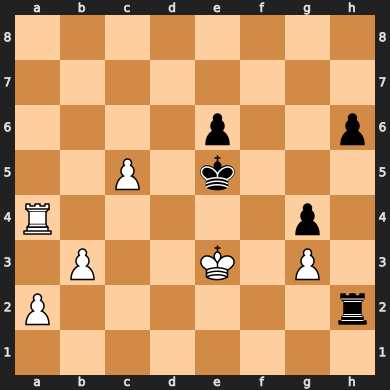

In [ ]:
# df.drop(columns=['FEN','Board'])
print(df['Codified_board'].iloc[0])
df['Board'].iloc[0]

In [ ]:
def center(board):
    return np.sum(board[3:5,3:5])

tqdm.pandas(desc="Adding column 'Center'")
df['Center'] = df['Codified_board'].progress_apply(center)

Adding column 'Center': 100%|██████████| 12959/12959 [00:00<00:00, 57088.77it/s] 


In [ ]:
correlations = df.corr(numeric_only=True)['Evaluation']
sorted_correlations = correlations.reindex(correlations.abs().sort_values(ascending=False).index)
print("Correlacions amb 'Evaluation' (ordenades per valor absolut):")
print(sorted_correlations)

Correlacions amb 'Evaluation' (ordenades per valor absolut):
Evaluation                  1.000000
Attacks_difference          0.229004
Material_difference         0.204433
White_attacks               0.075941
Center                      0.072232
White_pieces_count          0.059868
White_material              0.047074
Black_attacks              -0.044812
Doubled_pawns_difference    0.027851
Black_pieces_count         -0.027557
Black_doubled_pawns        -0.025745
Black_attacked              0.021810
Turn                        0.019445
White_doubled_pawns         0.012586
White_attacked              0.011200
Black_material             -0.009018
Attacked_difference         0.008568
En_passant                  0.004485
Black_queen_castling        0.002072
White_queen_castling        0.001720
N_moves                    -0.001247
Black_king_castling         0.001151
White_king_castling        -0.000132
Name: Evaluation, dtype: float64


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
clf = RandomForestRegressor()

X, y = df.drop(columns=[target, 'FEN', 'Board']), df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

r2_score(y_test, y_pred)

ValueError: setting an array element with a sequence.

## References

1. [Chess Piece Relative Value - Wikipedia](https://en.wikipedia.org/wiki/Chess_piece_relative_value)